In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from functools import reduce 

from sklearn import tree
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.metrics import roc_auc_score

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
train_data = pd.read_csv('Project2_Train.csv')
test_data = pd.read_csv('Project2_Test.csv')
test_data = test_data.rename({'Damage': 'VehicleDamage'}, axis=1)

In [4]:
def preprocess(data, oneHotEncodedCategories, drop_mystery):
    return_data = data.copy()
    for cat in oneHotEncodedCategories:
        encoder = OneHotEncoder()
        if (cat == 'Mystery'):
            encoder = OneHotEncoder(drop='first')
        encoder_df = pd.DataFrame(encoder.fit_transform(return_data[[cat]]).toarray())
        encoder_df.columns = [cat + " " + name.split('_', 1)[1] for name in encoder.get_feature_names()]
        return_data = return_data.join(encoder_df)
        return_data.drop(cat, axis = 1, inplace = True)
    if drop_mystery:
        return_data.drop('Mystery', axis = 1, inplace = True)
    return return_data

In [5]:
# Part 1
X_train_before = train_data[['Gender', 'Age', 'Region_Code', 'Age.1', 'VehicleDamage', 'Premium', 'Vintage', 'Mystery']]
y_train = train_data['Response']
X_test_before = test_data[['Gender', 'Age', 'Region_Code', 'Age.1', 'VehicleDamage', 'Premium', 'Vintage', 'Mystery']]
y_test = test_data['Response']

X_train = preprocess(X_train_before, ['Gender', 'Region_Code', 'VehicleDamage', 'Age.1'], True)
X_test = preprocess(X_test_before, ['Gender', 'Region_Code', 'VehicleDamage', 'Age.1'], True)

In [6]:
def train_one_model(estimator, param_grid, X_train = X_train, y_train = y_train):
    grid_rf_class = GridSearchCV(
        estimator = estimator,
        param_grid = param_grid,
        scoring = 'roc_auc',
        n_jobs = -4,
        cv = StratifiedKFold(random_state = 99, shuffle = True),
        refit = True,
        return_train_score = True
    )
    
    grid_rf_class.fit(X_train, y_train)

    return grid_rf_class

In [7]:
estimator_names = ["Logistic Regression", "Decision Tree", "Bagging Classifier","AdaBoost Classifier", "Gradient Boost"]
estimators = [LogisticRegression(penalty='none'), 
              DecisionTreeClassifier(), 
              BaggingClassifier(n_jobs = -4, random_state = 99), 
              AdaBoostClassifier(random_state = 99), 
              GradientBoostingClassifier(random_state = 99)]

grids = []

param_grids = [{}, 
               {
                   'max_depth': range(2, 5, 1),
                   'min_samples_leaf': np.linspace(0.01, 0.3, 10),
                   'max_leaf_nodes': range(2, 8, 1)
               },
               {
                   'max_samples': np.linspace(0.1, 1.0, 5),
                   'n_estimators': range(10, 60, 5),
                   'base_estimator': [DecisionTreeClassifier(max_depth = i) for i in range(2, 5, 1)]
               },
               {
                   'learning_rate': np.linspace(0.01, 0.2, 5),
                   'n_estimators': range(10, 60, 5),
                   'base_estimator': [DecisionTreeClassifier(max_depth = i) for i in range(2, 5, 1)]
               },
               {
                   'learning_rate': np.linspace(0.01, 0.2, 5),
                   'n_estimators': range(10, 60, 5),
                   'max_depth': range(2, 5, 1)
               }
              ]

In [8]:
for i in range(0, len(estimators)):
    print('--------------------------')
    
    grid_rf_class = train_one_model(estimators[i], param_grids[i])
    grids.append(grid_rf_class)
    
    print(estimator_names[i] + ' Done')
    print('best cv score: ' + str(grid_rf_class.best_score_))
    print('best params: ' + str(grid_rf_class.best_params_))
    
    print('--------------------------')

--------------------------
Logistic Regression Done
best cv score: 0.6110685873952832
best params: {}
--------------------------
--------------------------
Decision Tree Done
best cv score: 0.8180951328009384
best params: {'max_depth': 3, 'max_leaf_nodes': 7, 'min_samples_leaf': 0.07444444444444444}
--------------------------
--------------------------
Bagging Classifier Done
best cv score: 0.8249361892457104
best params: {'base_estimator': DecisionTreeClassifier(max_depth=4), 'max_samples': 1.0, 'n_estimators': 45}
--------------------------
--------------------------
AdaBoost Classifier Done
best cv score: 0.8239766268265557
best params: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.0575, 'n_estimators': 45}
--------------------------
--------------------------
Gradient Boost Done
best cv score: 0.8265650397156818
best params: {'learning_rate': 0.105, 'max_depth': 3, 'n_estimators': 40}
--------------------------


In [9]:
# This is just used to save models
import joblib
import pickle

for i in range(0, len(estimators)):
    filename = estimator_names[i] + ".joblib"
    joblib.dump(grids[i], filename)

In [24]:
# This is just to regenerate GridSearchCV results without retraining them
import joblib
import pickle

grids = []

for i in range(0, len(estimators)):
    filename = estimator_names[i] + ".joblib"
    loaded_model = joblib.load(filename)
    grids.append(loaded_model)

In [10]:
disp = {}

for i in range(len(grids)):
    disp[estimator_names[i]] = {
        'Best Avg CV Score (AUC)': grids[i].best_score_,
        'Refit Time': grids[i].refit_time_
    }
    
df = pd.DataFrame(data=disp).T

df

,Best Avg CV Score (AUC),Refit Time
Logistic Regression,0.611069,0.035941
Decision Tree,0.818095,0.013168
Bagging Classifier,0.824936,0.254621
AdaBoost Classifier,0.823977,0.270477
Gradient Boost,0.826565,0.283890


In [11]:
dt_grid = grids[1]
dt = dt_grid.best_estimator_

print('best parameters: ', dt_grid.best_params_)

best parameters:  {'max_depth': 3, 'max_leaf_nodes': 7, 'min_samples_leaf': 0.07444444444444444}


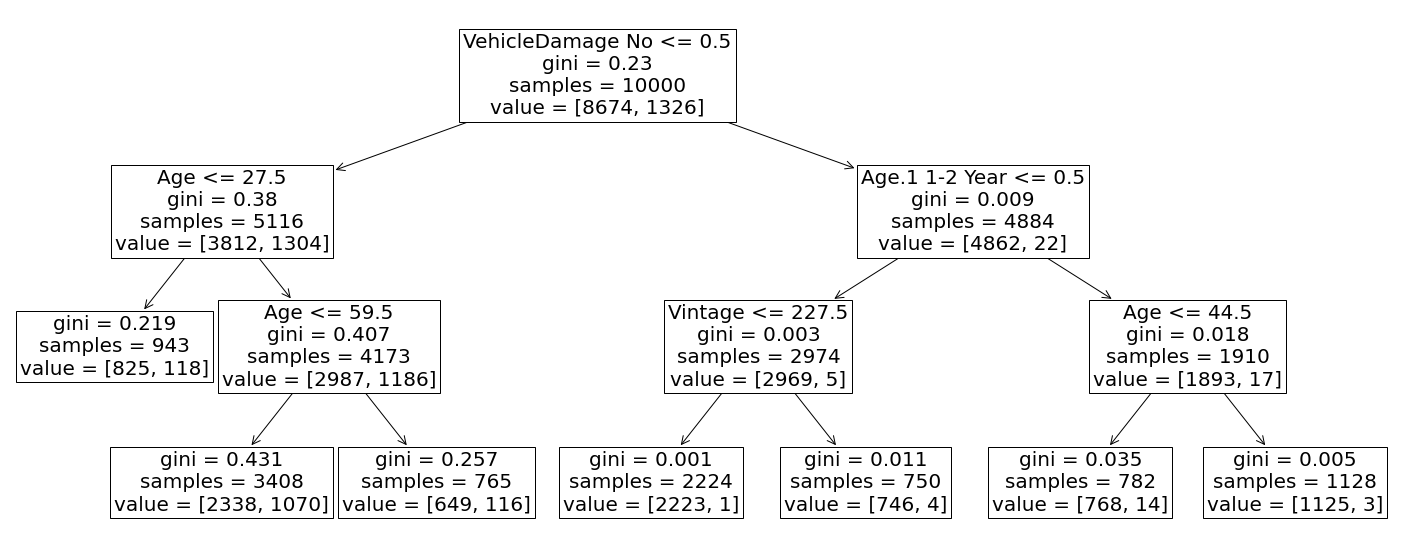

In [12]:
fig = plt.figure(figsize=(25,10))
_ = tree.plot_tree(dt, 
                   feature_names=X_train.columns,
                   fontsize = 20)

In [13]:
def combine_one_hot_encoded_covariates_importances(columns, importances, one_hot_encoded_vars):
    vars_substr = [x[0:5] for x in one_hot_encoded_vars]
    new_col_importances = {}
    for i, column in enumerate(columns):
        if column[0:5] in vars_substr:
            if column.split(' ')[0] not in new_col_importances:
                new_col_importances[column.split(' ')[0]] = importances[i]
            else:
                new_col_importances[column.split(' ')[0]] += importances[i]
        else:
            new_col_importances[column] = importances[i]
    return [list(new_col_importances.keys()), list(new_col_importances.values())]

In [14]:
def addlabels(x,y):
    props = dict(boxstyle='round', edgecolor='red', facecolor='None')
    for i in range(len(x)):
        plt.text(i, y[i] + 0.01, f'{y[i]:.4f}', ha = 'center', bbox = props if x[i] == 'Mystery' else None)

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

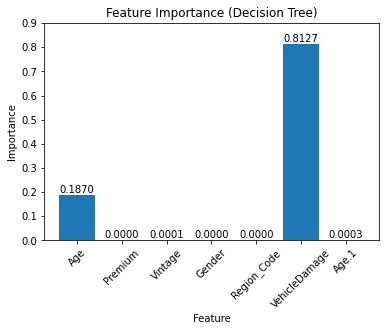

In [15]:
importances = dt.feature_importances_
columns = X_train.columns

columns, importances = combine_one_hot_encoded_covariates_importances(columns, 
                                                                      importances, 
                                                                      ['Gender', 'Region_Code', 'VehicleDamage', 'Age.1'])

plt.bar(columns, importances)
addlabels(columns, importances)
plt.ylim([0, 0.9])

plt.title('Feature Importance (Decision Tree)')
plt.xlabel('Feature')
plt.ylabel('Importance')
    
plt.xticks(rotation=45)

In [16]:
auc_cv = dt_grid.best_score_
y_pred = dt.predict_proba(X_test)[:, 1]
auc_test = roc_auc_score(y_test, y_pred)

print("CV AUC Score: ", auc_cv)
print("Test AUC Score: ", auc_test)

CV AUC Score:  0.8180951328009384
Test AUC Score:  0.8131651808089713


In [86]:
# Part 2
X_train_before = train_data[['Gender', 'Age', 'Region_Code', 'Age.1', 'VehicleDamage', 'Premium', 'Vintage', 'Mystery']]
y_train = train_data['Response']
X_test_before = test_data[['Gender', 'Age', 'Region_Code', 'Age.1', 'VehicleDamage', 'Premium', 'Vintage', 'Mystery']]
y_test = test_data['Response']

X_train_dummy = preprocess(X_train_before, ['Gender', 'Region_Code', 'VehicleDamage', 'Age.1', 'Mystery'], False)
X_test_dummy = preprocess(X_test_before, ['Gender', 'Region_Code', 'VehicleDamage', 'Age.1', 'Mystery'], False)

categories = ['M' + str(x) for x in range(1, 21)]
enc = OrdinalEncoder(categories=[categories])

X_train_int = preprocess(X_train_before, ['Gender', 'Region_Code', 'VehicleDamage', 'Age.1'], False)
X_train_int[["Mystery"]] = enc.fit_transform(X_train_int[["Mystery"]])

X_test_int = preprocess(X_test_before, ['Gender', 'Region_Code', 'VehicleDamage', 'Age.1'], False)
X_test_int[["Mystery"]] = enc.fit_transform(X_test_int[["Mystery"]])

In [87]:
rf = RandomForestClassifier(random_state = 99)
params = {
    'max_samples': np.linspace(0.1, 1.0, 5),
    'n_estimators': range(10, 60, 5),
    'max_depth': range(2, 5, 1)
}

rf_grid_dummy = train_one_model(rf, params, X_train_dummy, y_train)
rf_grid_int = train_one_model(rf, params, X_train_int, y_train)

In [88]:
columns_dummy = X_train_dummy.columns
columns_int = X_train_int.columns

dummy_importances = rf_grid_dummy.best_estimator_.feature_importances_
int_importances = rf_grid_int.best_estimator_.feature_importances_

columns_dummy, dummy_importances = combine_one_hot_encoded_covariates_importances(columns_dummy, 
                                                          dummy_importances, 
                                                          ['Gender', 'Region_Code', 'VehicleDamage', 'Age.1', 'Mystery'])

columns_int, int_importances = combine_one_hot_encoded_covariates_importances(columns_int, 
                                                          int_importances, 
                                                          ['Gender', 'Region_Code', 'VehicleDamage', 'Age.1'])

Importance of Mystery 0.029496971932044976


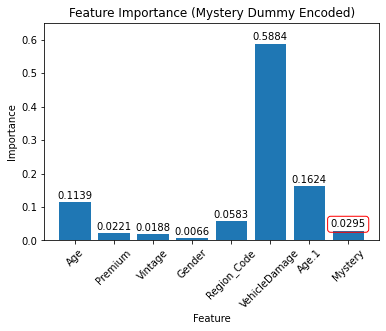

In [89]:
plt.bar(columns_dummy, dummy_importances)

addlabels(columns_dummy, dummy_importances)
plt.ylim([0, 0.65])

plt.title('Feature Importance (Mystery Dummy Encoded)')
plt.xlabel('Feature')
plt.ylabel('Importance')
    
plt.xticks(rotation=45)

i = columns_dummy.index('Mystery')
print('Importance of Mystery', dummy_importances[i])

Importance of Mystery 0.006808317552415448


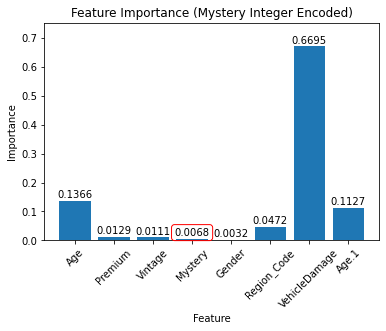

In [90]:
plt.bar(columns_int, int_importances)
addlabels(columns_int, int_importances)
plt.ylim([0, 0.75])

plt.title('Feature Importance (Mystery Integer Encoded)')
plt.xlabel('Feature')
plt.ylabel('Importance')
    
plt.xticks(rotation=45)

i = columns_int.index('Mystery')
print('Importance of Mystery', int_importances[i])

In [91]:
def convert_to_benefit(y_pred, y_actual, promote_interested, miss_interested, promote_uninterested, promotion):
    if y_pred == 1 and y_actual == 1:
        return promote_interested + promotion
    elif y_pred == 1 and y_actual == 0:
        return promote_uninterested + promotion
    elif y_pred == 0 and y_actual == 0:
        return 0
    elif y_pred == 0 and y_actual == 1:
        return miss_interested

In [103]:
# Discussion 2
y_prob = dt.predict_proba(X_train)[:, 1]

thresholds = [0.01, 0.1, 0.2, 0.5]
benefits = []

for threshold in thresholds:
    y_pred = [1 if y > threshold else 0 for y in y_prob]
    y_pred_actual = zip(y_pred, y_train)
    benefit = [convert_to_benefit(pred_actual[0], pred_actual[1], 10, -10, -2, -1) for pred_actual in y_pred_actual]
    benefits.append(sum(benefit))

df = pd.DataFrame({'Thresholds': thresholds, 'Benefits': benefits})
df

,Thresholds,Benefits
0,0.01,-1958
1,0.10,80
2,0.20,56
3,0.50,-13260


In [104]:
# Discussion 3
y_prob = dt.predict_proba(X_train)[:, 1]

thresholds = [0.01, 0.1, 0.2, 0.5]
benefits = []

for threshold in thresholds:
    y_pred = [1 if y > threshold else 0 for y in y_prob]
    y_pred_actual = zip(y_pred, y_train)
    benefit = [convert_to_benefit(pred_actual[0], pred_actual[1], 100, -100, -2, -1) for pred_actual in y_pred_actual]
    benefits.append(sum(benefit))

df = pd.DataFrame({'Thresholds': thresholds, 'Benefits': benefits})
df

,Thresholds,Benefits
0,0.01,115942
1,0.10,115460
2,0.20,73316
3,0.50,-132600


In [17]:
# Discussion 4
lr = LogisticRegression(penalty='none')
gb = GradientBoostingClassifier(random_state = 99)

eclf = VotingClassifier(
    estimators=[('lr', lr), ('gb', gb)],
    voting='soft'
)

params = {
   'gb__learning_rate': np.linspace(0.01, 0.2, 5),
   'gb__n_estimators': range(10, 60, 5),
   'gb__max_depth': range(2, 5, 1)
}

grid_combined = train_one_model(eclf, params)

In [18]:
cv_scores = [x.best_score_ for x in grids]
cv_scores.append(grid_combined.best_score_)

estimator_names_appended = estimator_names + ["Logistic Regression + Gradient Boosting"]

compiled = {"Model": estimator_names_appended, "CV Score": cv_scores}
df = pd.DataFrame(compiled)
df

,Model,CV Score
0,Logistic Regression,0.611069
1,Decision Tree,0.818095
2,Bagging Classifier,0.824936
3,AdaBoost Classifier,0.823977
4,Gradient Boost,0.826565
5,Logistic Regression + Gradient Boosting,0.813555
